In [369]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [295]:
# Get Data
billing_data = pd.read_csv('/Users/bhushanborude/Desktop/Projects/Python/Python for Machine Learning & Data Science Masterclass/FINN/billing_data.csv')
deal_data = pd.read_csv('/Users/bhushanborude/Desktop/Projects/Python/Python for Machine Learning & Data Science Masterclass/FINN/deal_data.csv')
customer_data = pd.read_csv('/Users/bhushanborude/Desktop/Projects/Python/Python for Machine Learning & Data Science Masterclass/FINN/customer_data.csv')

## Billing Data

In [407]:
# billing_data.head()

billing_data.info()

# billing_data.describe()

# billing_data['invoice_id'].nunique()

# total deals
# billing_data['deal_id'].nunique()

# invoice_types
# billing_data['invoice_type'].value_counts()

# invoice status
# billing_data['invoice_status'].value_counts()

# dunning status
# billing_data['dunning_status'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 15254 entries, 0 to 15686
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   invoice_id        15254 non-null  object        
 1   deal_id           15254 non-null  int64         
 2   invoice_type      15254 non-null  object        
 3   invoice_date      15254 non-null  datetime64[ns]
 4   invoice_due_date  15254 non-null  datetime64[ns]
 5   paid_date         15102 non-null  datetime64[ns]
 6   invoice_status    15254 non-null  object        
 7   dunning_status    1035 non-null   object        
 8   invoice_amount    15254 non-null  float64       
 9   delay_in_days     15102 non-null  float64       
 10  delay_bool        15254 non-null  bool          
 11  invoice_month     15254 non-null  int32         
 12  due_day           15254 non-null  int32         
dtypes: bool(1), datetime64[ns](3), float64(2), int32(2), int64(1), object(4)
memory u

In [297]:
# Removing the invoices where invoice_amount is negative or zero
billing_data = billing_data[billing_data['invoice_amount'] > 0]

# Date columns in proper datatype
billing_data['invoice_date'] = pd.to_datetime(billing_data['invoice_date'], format="%d/%m/%Y")
billing_data['invoice_due_date'] = pd.to_datetime(billing_data['invoice_due_date'], format="%d/%m/%Y")
billing_data['paid_date'] = pd.to_datetime(billing_data['paid_date'], format="%d/%m/%Y")

# Create a new column 'delay_in_days'
billing_data['delay_in_days'] = billing_data['paid_date'] - billing_data['invoice_due_date']

# Converting the column to days
billing_data['delay_in_days'] = billing_data['delay_in_days'].apply(lambda x: x.days)

# Delay as boolean
billing_data['delay_bool'] = (billing_data['delay_in_days'] > 0) | (pd.isnull(billing_data['delay_in_days']))

# Get the invoice month
billing_data['invoice_month'] = billing_data['invoice_date'].dt.month

# Get the due day
billing_data['due_day'] = billing_data['invoice_due_date'].dt.day

## Deal Data

In [406]:
# deal_data.head()

deal_data.info()

# deal_data.describe()

# deal_data['deal_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   deal_id              2392 non-null   int64  
 1   customer_id          2372 non-null   float64
 2   deal_term            2392 non-null   int64  
 3   deal_monthly_amount  2392 non-null   float64
 4   deal_signed_date     2392 non-null   object 
 5   deal_deposit_amount  2392 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 112.3+ KB


## Customer Data

In [408]:
# customer_data.head()

customer_data.info()

# customer_data.describe()

# customer_data['customer_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     2299 non-null   float64       
 1   schufa_score    1717 non-null   float64       
 2   postal_code     1722 non-null   float64       
 3   date_of_birth   2297 non-null   datetime64[ns]
 4   loyalty_status  2218 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 89.9+ KB


In [300]:
# Date of birth to_datetime
customer_data['date_of_birth'] = pd.to_datetime(customer_data['date_of_birth'], format="%d/%m/%Y")

# Drop duplicate rows
customer_data = customer_data.drop_duplicates()

# Get repeated customer ids
repeated_customer_ids = customer_data['customer_id'].value_counts() 
repeated_customer_ids = repeated_customer_ids[repeated_customer_ids > 1].index

# For repeated customer_ids, calculating average schufa_score
agg_funcs = {
    'schufa_score': lambda x: np.floor(x.mean(skipna=True)),
    'postal_code': 'first',
    'date_of_birth': 'first',
    'loyalty_status' : 'first'
}

customer_data = customer_data.groupby('customer_id').agg(agg_funcs).reset_index()

## Merged Data

In [302]:
merged_df = pd.merge(billing_data, deal_data, on='deal_id', how = 'left')
merged_df = pd.merge(merged_df, customer_data, on='customer_id', how = 'left')

# Schufa Score Grouped
bins_schufa = [0, 6999, 7999, 8499, 8999, 9249, 9499, 9749, 10000]
labels_schufa = ['0 - 6,999', '7,000 - 7,999', '8,000 - 8,499', '8,500 - 8,999', '9,000 - 9,249', '9,250 - 9,499', '9,500 - 9,749', '9,750 - 10000']
merged_df['schufa_group'] = pd.cut(merged_df['schufa_score'], bins=bins_schufa, labels=labels_schufa, right=True, include_lowest=True)

# deposite boolean column
merged_df['deposit'] = merged_df['deal_deposit_amount'].apply(lambda x : True if x > 0 else False)

# Deal Term Grouped
bins_deal_term = [0, 6, 12, 18, 24]
labels_deal_term = ['0 - 6', '7 - 12', '13 - 18', '18 - 24']
merged_df['deal_term_group'] = pd.cut(merged_df['deal_term'], bins=bins_deal_term, labels=labels_deal_term, right=True, include_lowest=True)

# Deal Monthly Amount Grouped
bins_deal_monthly_amount = [0, 499, 999, 1499, 1999, 2999, 3999]
labels_deal_monthly_amount = ['0 - 499', '500 - 999', '1,000 - 1,499', '1,500 - 1,999', '2,000 - 2,999', '3,000 - 3,999']
merged_df['deal_monthly_amount_group'] = pd.cut(merged_df['deal_monthly_amount'], bins=bins_deal_monthly_amount, labels=labels_deal_monthly_amount, right=True, include_lowest=True)

# Invoice Amount Grouped
bins_invoice_amount = [0, 499, 999, 1499, 1999, 30000]
labels_invoice_amount = ['0 - 499', '500 - 999', '1,000 - 1,499', '1,500 - 1,999', '>1,999']
merged_df['invoice_amount_group'] = pd.cut(merged_df['invoice_amount'], bins=bins_invoice_amount, labels=labels_invoice_amount, right=True, include_lowest=True)

# Calculate Customer Age
def calculate_age(dob, invoice_date):
    return invoice_date.year - dob.year - ((invoice_date.month, invoice_date.day) < (dob.month, dob.day))

merged_df['age'] = merged_df.apply(lambda row: calculate_age(row['date_of_birth'], row['invoice_date']), axis=1)

# Age Grouped
bins_age = [10, 20, 30, 40, 50, 60, 70, 80, 90]
labels_age = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']

merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins_age, labels=labels_age, right=False)

# Due Date Grouped
bins_due_day = [0, 2, 7, 12, 17, 22, 27, 32]
labels_due_day = ['1-2', '3-7', '8-12', '13-17', '18-22', '23-27', '28-31']
merged_df['due_day_group'] = pd.cut(merged_df['due_day'], bins=bins_due_day, labels=labels_due_day, right=False, include_lowest=True)

## EDA

In [304]:
# Total number of invoices
total_invoices = merged_df['invoice_id'].count()

# Number of delayed invoices 
delayed_invoices = merged_df[merged_df['delay_bool']]['invoice_id'].count()

# Percentage of delayed invoices 
delayed_invoices_perc = round((delayed_invoices / total_invoices) * 100, 2)

print("Total invoices : {}".format(total_invoices))
print("Delayed invoices : {}".format(delayed_invoices))
print("Percentage of delayed invoices : {}".format(delayed_invoices_perc))

Total invoices : 15254
Delayed invoices : 986
Percentage of delayed invoices : 6.46


In [305]:
# Total Unique Customers
total_unique_cust = merged_df['customer_id'].nunique()

# Delaying Customers 
total_delaying_cust = merged_df[merged_df['delay_bool']]['customer_id'].nunique()

# Percentage of Delaying Customers
total_delaying_cust_perc = round((total_delaying_cust / total_unique_cust) * 100, 2)

print("Total customers : {}".format(total_unique_cust))
print("Delaying customers : {}".format(total_delaying_cust))
print("Percentage of Delaying customers : {}".format(total_delaying_cust_perc))


Total customers : 2260
Delaying customers : 559
Percentage of Delaying customers : 24.73


In [306]:
# Total invoices generated by month
total_invoices_by_month = merged_df.groupby(['invoice_month'])['invoice_id'].count()

# Delayed invoices by month
delayed_invoices_by_month = merged_df[merged_df['delay_bool']].groupby(['invoice_month'])['invoice_id'].count()

# Share of invoices with a delayed payment by month
delayed_invoices_by_month_perc = round((delayed_invoices_by_month / total_invoices_by_month) * 100, 2)
delayed_invoices_by_month_perc

invoice_month
1     5.44
2     5.14
3     5.95
4     4.42
5     6.94
6     8.33
7     5.42
8     6.71
9     6.72
10    6.61
11    7.26
12    8.16
Name: invoice_id, dtype: float64

In [409]:
# Total invoices where invoice type = monthly by month
monthly_total_invoices_by_month = merged_df[merged_df['invoice_type'] == 'monthly'].groupby(['invoice_month'])['invoice_id'].count()

# Delayed invoices where invoice type = monthly by month
monthly_delayed_invoices_by_month = merged_df[(merged_df['invoice_type'] == 'monthly') & 
                                (merged_df['delay_bool'])].groupby(['invoice_month'])['invoice_id'].count()

# Total invoices where invoice type = final by month
final_total_invoices_by_month = merged_df[merged_df['invoice_type'] == 'final'].groupby(['invoice_month'])['invoice_id'].count()

# Delayed invoices where invoice type = final by month
final_delayed_invoices_by_month = merged_df[(merged_df['invoice_type'] == 'final') & 
                                (merged_df['delay_bool'])].groupby(['invoice_month'])['invoice_id'].count()

# For invoice_type = 'monthly', what is the share of delayed invoices
monthly_delayed_invoices_by_month_perc = round((monthly_delayed_invoices_by_month / monthly_total_invoices_by_month) * 100, 2)

# For invoice_type = 'final', what is the share of delayed invoices
final_delayed_invoices_by_month_perc = round((final_delayed_invoices_by_month / final_total_invoices_by_month) * 100, 2)

# In all the invoices generated by month, what is the share of invoices where the invoice_type = 'monthly'
monthly_total_invoices_share = round((monthly_total_invoices_by_month / total_invoices_by_month) * 100, 2)

# In all the invoices generated by month, what is the share of invoices where the invoice_type = 'final'
final_total_invoices_share = round((final_total_invoices_by_month / total_invoices_by_month) * 100, 2)

# In all the delayed invoices by month, what is the share of invoices where the invoice_type = 'monthly'
monthly_delayed_invoices_share = round((monthly_delayed_invoices_by_month / delayed_invoices_by_month) * 100, 2)

# In all the delayed invoices by month, what is the share of invoices where the invoice_type = 'final'
final_delayed_invoices_share = round((final_delayed_invoices_by_month / delayed_invoices_by_month) * 100, 2)

# Creat a dataframe for above metrics
output_df = pd.DataFrame({
    'total_invoices' : total_invoices_by_month,
    'monthly_invoices' : monthly_total_invoices_by_month,
    'monthly_invoices_share' : monthly_total_invoices_share,
    'final_invoices' : final_total_invoices_by_month,
    'final_invoices_share' : final_total_invoices_share,
    'delayed_total' : delayed_invoices_by_month,
    'delayed_monthly' : monthly_delayed_invoices_by_month,
    'delayed_monthly_share' : monthly_delayed_invoices_share,
    'delayed_final' : final_delayed_invoices_by_month,
    'delayed_final_share' : final_delayed_invoices_share,
    'delayed_total_perc' : delayed_invoices_by_month_perc,
    'delayed_monthly_perc' : monthly_delayed_invoices_by_month_perc,
    'delayed_final_perc' : final_delayed_invoices_by_month_perc
})

output_df

,total_invoices,monthly_invoices,monthly_invoices_share,final_invoices,final_invoices_share,delayed_total,delayed_monthly,delayed_monthly_share,delayed_final,delayed_final_share,delayed_total_perc,delayed_monthly_perc,delayed_final_perc
invoice_month,,,,,,,,,,,,,
1,1122,1074,95.72,48,4.28,61,42,68.85,19,31.15,5.44,3.91,39.58
2,1187,1126,94.86,61,5.14,61,35,57.38,26,42.62,5.14,3.11,42.62
3,1243,1191,95.82,52,4.18,74,43,58.11,31,41.89,5.95,3.61,59.62
4,1176,1146,97.45,30,2.55,52,37,71.15,15,28.85,4.42,3.23,50.00
5,1340,1292,96.42,48,3.58,93,66,70.97,27,29.03,6.94,5.11,56.25
6,1309,1224,93.51,85,6.49,109,59,54.13,50,45.87,8.33,4.82,58.82
7,1311,1269,96.80,42,3.20,71,53,74.65,18,25.35,5.42,4.18,42.86
8,1342,1276,95.08,66,4.92,90,56,62.22,34,37.78,6.71,4.39,51.52
9,1325,1263,95.32,62,4.68,89,58,65.17,31,34.83,6.72,4.59,50.00


## Univariate Analysis

### Invoice Type

In [309]:
# Count the number of invoices for each invoice type
invoice_count_by_type = merged_df.groupby(['invoice_type'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for each invoice type
delayed_invoice_count_by_type = merged_df[merged_df['delay_bool']].groupby(['invoice_type'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for each invoice type
percentage_delayed_by_type = round((delayed_invoice_count_by_type / invoice_count_by_type) * 100, 2)

# Create a DataFrame combining the three series
invoice_type_df = pd.DataFrame({
    'invoice_count': invoice_count_by_type,
    'delayed_invoice_count': delayed_invoice_count_by_type,
    'percentage_delayed': percentage_delayed_by_type
})

invoice_type_df

,invoice_count,delayed_invoice_count,percentage_delayed
invoice_type,,,
final,689,349,50.65
monthly,14565,637,4.37


### Due Day Group

In [310]:
# Count the number of invoices for each due_day_group
invoice_count_by_due_day_group = merged_df.groupby(['due_day_group'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for due_day_group
delayed_invoice_count_by_due_day_group = merged_df[merged_df['delay_bool']].groupby(['due_day_group'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for each due_day_group
percentage_delayed_by_due_day_group = round((delayed_invoice_count_by_due_day_group / invoice_count_by_due_day_group) * 100, 2)

# Create a DataFrame combining the three series
due_day_group_df = pd.DataFrame({
    'invoice_count': invoice_count_by_due_day_group,
    'delayed_invoice_count': delayed_invoice_count_by_due_day_group,
    'percentage_delayed': percentage_delayed_by_due_day_group
})

due_day_group_df

,invoice_count,delayed_invoice_count,percentage_delayed
due_day_group,,,
1-2,515,31,6.02
3-7,2450,112,4.57
8-12,2016,139,6.89
13-17,2532,174,6.87
18-22,2430,153,6.30
23-27,2650,202,7.62
28-31,2661,175,6.58


### Invoice Amount Group

In [311]:
# Count the number of invoices for each invoice_amount_group
invoice_count_by_invoice_amount_group = merged_df.groupby(['invoice_amount_group'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for each invoice_amount_group
delayed_invoice_count_by_invoice_amount_group = merged_df[merged_df['delay_bool']].groupby(['invoice_amount_group'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for each invoice_amount_group
percentage_delayed_by_invoice_amount_group = round((delayed_invoice_count_by_invoice_amount_group / invoice_count_by_invoice_amount_group) * 100, 2)

# Create a DataFrame combining the three series
invoice_amount_group_df = pd.DataFrame({
    'invoice_count': invoice_count_by_invoice_amount_group,
    'delayed_invoice_count': delayed_invoice_count_by_invoice_amount_group,
    'percentage_delayed': percentage_delayed_by_invoice_amount_group
})

invoice_amount_group_df


,invoice_count,delayed_invoice_count,percentage_delayed
invoice_amount_group,,,
0 - 499,6919,406,5.87
500 - 999,6924,362,5.23
"1,000 - 1,499",1052,92,8.75
"1,500 - 1,999",186,39,20.97
">1,999",173,87,50.29


### Deal Term Group

In [312]:
# Count the number of invoices for each deal_term_group
invoice_count_by_deal_term_group = merged_df.groupby(['deal_term_group'])['invoice_id'].count()

# Count the number of delayed invoices for each deal_term_group
delayed_invoice_count_by_deal_term_group = merged_df[merged_df['delay_bool']].groupby(['deal_term_group'])['invoice_id'].count()

# Calculate the percentage of delayed invoices (where delay_bool is True) for each deal_term_group
percentage_delayed_by_deal_term_group = round((delayed_invoice_count_by_deal_term_group / invoice_count_by_deal_term_group) * 100, 2)

# Create a DataFrame combining the three series
deal_term_group_df = pd.DataFrame({
    'invoice_count': invoice_count_by_deal_term_group,
    'delayed_invoice_count': delayed_invoice_count_by_deal_term_group,
    'percentage_delayed': percentage_delayed_by_deal_term_group
})

deal_term_group_df


,invoice_count,delayed_invoice_count,percentage_delayed
deal_term_group,,,
0 - 6,1852,155,8.37
7 - 12,9885,610,6.17
13 - 18,2814,161,5.72
18 - 24,703,60,8.53


### Deal Monthly Amount Group

In [313]:
# Count the number of invoices for each deal_monthly_amount_group
invoice_count_by_deal_monthly_amount_group = merged_df.groupby(['deal_monthly_amount_group'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for each deal_monthly_amount_group
delayed_invoice_count_by_deal_monthly_amount_group = merged_df[merged_df['delay_bool']].groupby(['deal_monthly_amount_group'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for each deal_monthly_amount_group
percentage_delayed_by_deal_monthly_amount_group = round((delayed_invoice_count_by_deal_monthly_amount_group / invoice_count_by_deal_monthly_amount_group) * 100, 2)

# Create a DataFrame combining the three series
deal_monthly_amount_group_df = pd.DataFrame({
    'invoice_count': invoice_count_by_deal_monthly_amount_group,
    'delayed_invoice_count': delayed_invoice_count_by_deal_monthly_amount_group,
    'percentage_delayed': percentage_delayed_by_deal_monthly_amount_group
})

deal_monthly_amount_group_df

,invoice_count,delayed_invoice_count,percentage_delayed
deal_monthly_amount_group,,,
0 - 499,6530,375,5.74
500 - 999,7516,503,6.69
"1,000 - 1,499",1027,83,8.08
"1,500 - 1,999",142,14,9.86
"2,000 - 2,999",28,7,25.00
"3,000 - 3,999",11,4,36.36


### Deal Deposit (Boolean)

In [314]:
# Count the number of invoices for deal deposit(Boolean)
invoice_count_by_deal_deposit = merged_df.groupby(['deposit'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for deal deposit(Boolean)
delayed_invoice_count_by_deal_deposit = merged_df[merged_df['delay_bool']].groupby(['deposit'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for deal deposit(Boolean)
percentage_delayed_by_deal_deposit = round((delayed_invoice_count_by_deal_deposit / invoice_count_by_deal_deposit) * 100, 2)

# Create a DataFrame combining the three series
deal_deposit_df = pd.DataFrame({
    'invoice_count': invoice_count_by_deal_deposit,
    'delayed_invoice_count': delayed_invoice_count_by_deal_deposit,
    'percentage_delayed': percentage_delayed_by_deal_deposit
})

deal_deposit_df

,invoice_count,delayed_invoice_count,percentage_delayed
deposit,,,
False,14599,928,6.36
True,655,58,8.85


### Schufa Group

In [315]:
merged_df.columns# Count the number of invoices for each schufa_group
invoice_count_by_schufa_group = merged_df.groupby(['schufa_group'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for each schufa_group
delayed_invoice_count_by_schufa_group = merged_df[merged_df['delay_bool']].groupby(['schufa_group'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for each schufa_group
percentage_delayed_by_schufagroup = round((delayed_invoice_count_by_schufa_group / invoice_count_by_schufa_group) * 100, 2)

# Create a DataFrame combining the three series
schufa_group = pd.DataFrame({
    'invoice_count': invoice_count_by_schufa_group,
    'delayed_invoice_count': delayed_invoice_count_by_schufa_group,
    'percentage_delayed': percentage_delayed_by_schufagroup
})

schufa_group


,invoice_count,delayed_invoice_count,percentage_delayed
schufa_group,,,
"0 - 6,999",62,15,24.19
"7,000 - 7,999",180,25,13.89
"8,000 - 8,499",273,57,20.88
"8,500 - 8,999",705,91,12.91
"9,000 - 9,249",488,53,10.86
"9,250 - 9,499",948,107,11.29
"9,500 - 9,749",2184,134,6.14
"9,750 - 10000",6357,289,4.55


### Age Group

In [316]:
# Count the number of invoices for each age group
invoice_count_by_age_group = merged_df.groupby(['age_group'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for each age group
delayed_invoice_count_by_age_group = merged_df[merged_df['delay_bool']].groupby(['age_group'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for each age group
percentage_delayed_by_age_group = round((delayed_invoice_count_by_age_group / invoice_count_by_age_group) * 100, 2)

# Create a DataFrame combining the three series
age_group_df = pd.DataFrame({
    'invoice_count': invoice_count_by_age_group,
    'delayed_invoice_count': delayed_invoice_count_by_age_group,
    'percentage_delayed': percentage_delayed_by_age_group
})

age_group_df

,invoice_count,delayed_invoice_count,percentage_delayed
age_group,,,
10-19,7,0,0.00
20-29,1893,188,9.93
30-39,4298,273,6.35
40-49,4145,269,6.49
50-59,3278,157,4.79
60-69,1303,70,5.37
70-79,235,25,10.64
80-89,5,0,0.00


### Loyalty Status

In [317]:
# Count the number of invoices for each loyalty status
invoice_count_by_loyalty = merged_df.groupby(['loyalty_status'])['invoice_id'].count()

# Count the number of delayed invoices (where delay_bool is True) for each loyalty status
delayed_invoice_count_by_loyalty = merged_df[merged_df['delay_bool']].groupby(['loyalty_status'])['invoice_id'].count()

# Calculate the percentage of delayed invoices for each loyalty status
percentage_delayed_by_loyalty = round((delayed_invoice_count_by_loyalty / invoice_count_by_loyalty) * 100, 2)

# Create a DataFrame combining the three series
loyalty_status_df = pd.DataFrame({
    'invoice_count': invoice_count_by_loyalty,
    'delayed_invoice_count': delayed_invoice_count_by_loyalty,
    'percentage_delayed': percentage_delayed_by_loyalty
})

loyalty_status_df

,invoice_count,delayed_invoice_count,percentage_delayed
loyalty_status,,,
gold,9479,543,5.73
platinum,4543,239,5.26
silver,1008,139,13.79


## Bi-variate Analysis

### Schufa Group and Invoice Type

In [370]:
# Count of invoices 
pivot_01_count = pd.pivot_table(merged_df, index='schufa_group', columns='invoice_type', values='delay_bool', aggfunc='count')

# Sum of delayed invoices
pivot_01_sum = pd.pivot_table(merged_df, index='schufa_group', columns='invoice_type', values='delay_bool', aggfunc='sum')

# Percentage of delayed invoices
pivot_01 = round(pivot_01_sum / pivot_01_count * 100, 2)

print('Percentage of delayed invoices: ')
pivot_01


Percentage of delayed invoices: 


invoice_type,final,monthly
schufa_group,,
"0 - 6,999",100.00,18.97
"7,000 - 7,999",75.00,12.50
"8,000 - 8,499",69.23,18.46
"8,500 - 8,999",55.56,10.61
"9,000 - 9,249",62.50,7.24
"9,250 - 9,499",60.00,9.14
"9,500 - 9,749",45.92,4.27
"9,750 - 10000",44.41,2.61


Text(0.5, 1.0, 'Percentage of delayed invoices')

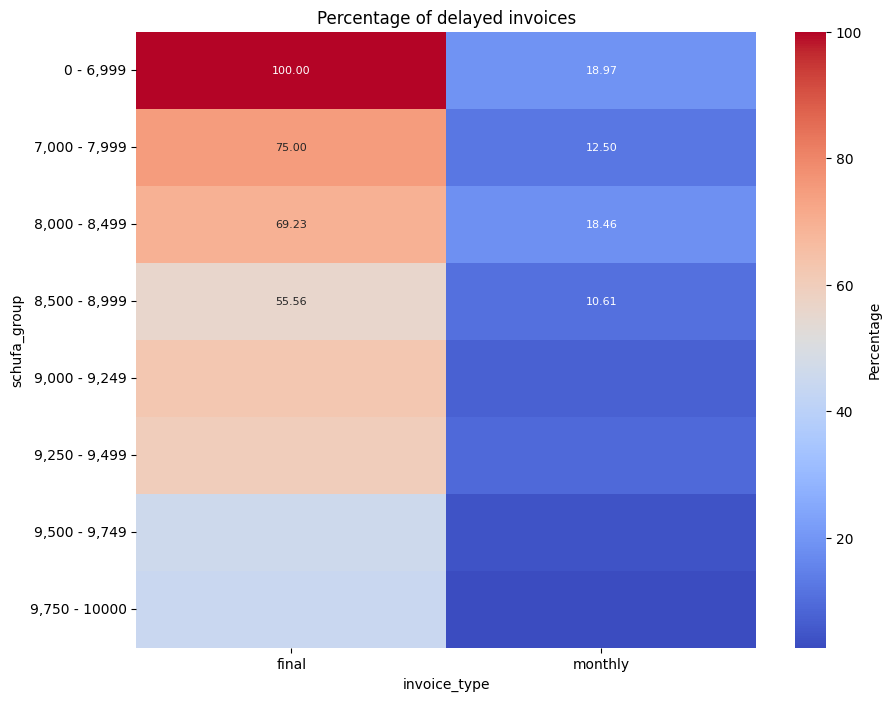

In [401]:
plt.figure(figsize=(10, 8))
heatmap_01 = sns.heatmap(pivot_01, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Percentage'}, annot_kws={'size': 8})
heatmap_01.set_title('Percentage of delayed invoices')

### Schufa Group and Loyalty Status

In [377]:
# Count of invoices 
pivot_02_count = pd.pivot_table(merged_df, index='schufa_group', columns='loyalty_status', values='delay_bool', aggfunc='count')

# Sum of delayed invoices
pivot_02_sum = pd.pivot_table(merged_df, index='schufa_group', columns='loyalty_status', values='delay_bool', aggfunc='sum')

# Percentage of delayed invoices
pivot_02 = round(pivot_02_sum / pivot_02_count * 100, 2)

print('Percentage of delayed invoices: ')
pivot_02

Percentage of delayed invoices: 


loyalty_status,gold,platinum,silver
schufa_group,,,
"0 - 6,999",11.90,50.00,42.86
"7,000 - 7,999",15.69,5.63,50.00
"8,000 - 8,499",16.20,19.35,50.00
"8,500 - 8,999",13.30,10.28,16.98
"9,000 - 9,249",8.12,7.84,20.83
"9,250 - 9,499",9.33,15.08,11.67
"9,500 - 9,749",4.21,7.82,11.63
"9,750 - 10000",3.99,3.85,9.53


Text(0.5, 1.0, 'Percentage of delayed invoices')

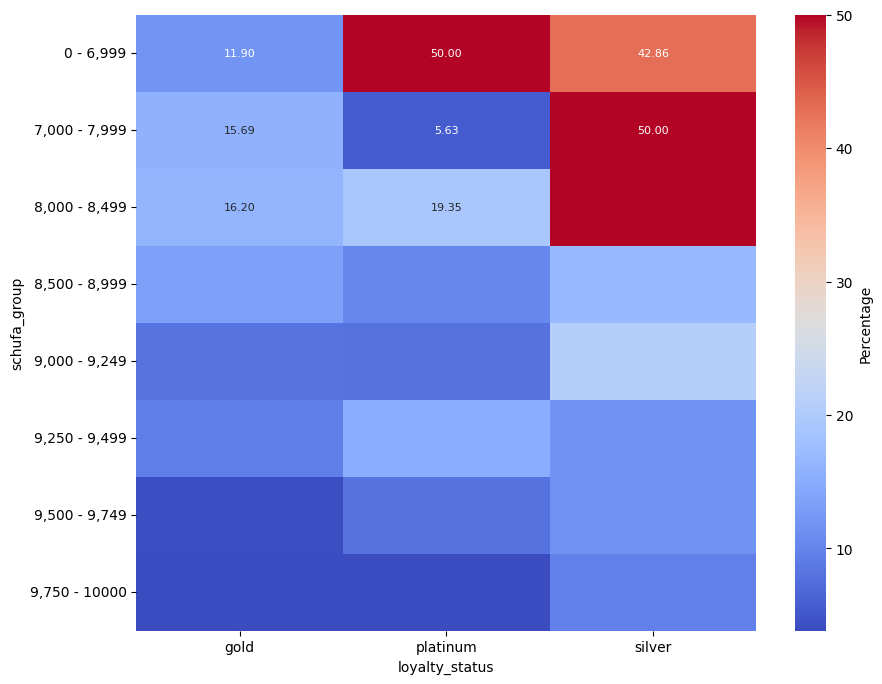

In [398]:
plt.figure(figsize=(10, 8))
heatmap_02 = sns.heatmap(pivot_02, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Percentage'}, annot_kws={'size': 8})
heatmap_02.set_title('Percentage of delayed invoices')

### Schufa Group and Invoice Amount Group

In [391]:
# Count of invoices 
pivot_03_count = pd.pivot_table(merged_df, index='schufa_group', columns='invoice_amount_group', values='delay_bool', aggfunc='count')

# Sum of delayed invoices
pivot_03_sum = pd.pivot_table(merged_df, index='schufa_group', columns='invoice_amount_group', values='delay_bool', aggfunc='sum')

# Percentage of delayed invoices
pivot_03 = round(pivot_03_sum / pivot_03_count * 100, 2)

print('Percentage of delayed invoices: ')
pivot_03

Percentage of delayed invoices: 


invoice_amount_group,0 - 499,500 - 999,"1,000 - 1,499","1,500 - 1,999",">1,999"
schufa_group,,,,,
"0 - 6,999",19.35,24.14,NaN,NaN,100.00
"7,000 - 7,999",15.28,7.87,50.00,28.57,40.00
"8,000 - 8,499",20.71,16.67,80.00,14.29,100.00
"8,500 - 8,999",10.26,12.97,12.96,9.09,90.91
"9,000 - 9,249",9.33,10.26,8.70,100.00,100.00
"9,250 - 9,499",7.55,8.73,38.46,80.00,80.00
"9,500 - 9,749",4.67,6.24,6.25,43.75,40.00
"9,750 - 10000",3.91,3.91,7.51,18.18,46.15


Text(0.5, 1.0, 'Percentage of delayed invoices')

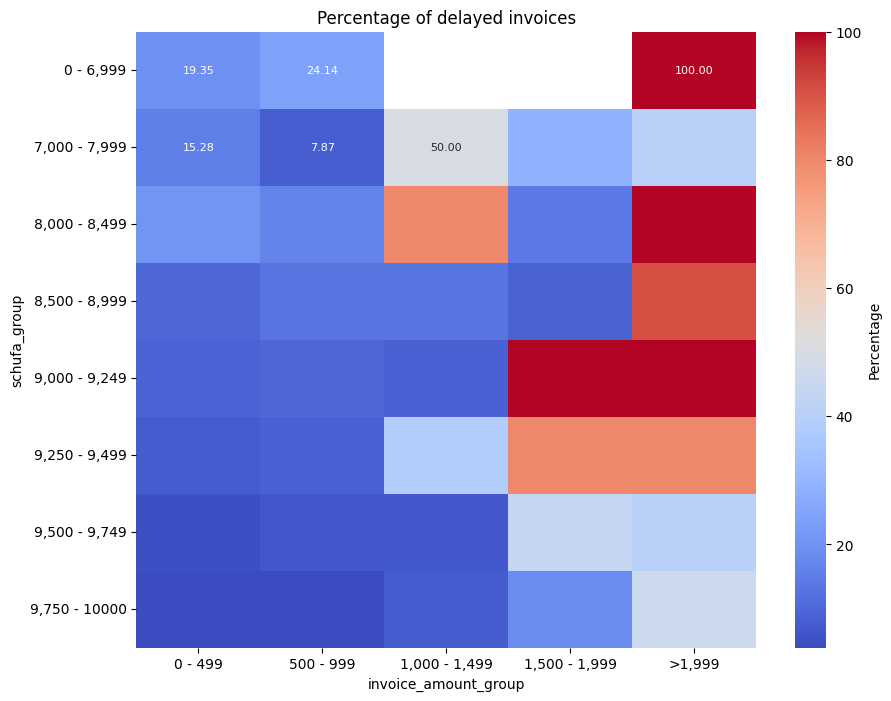

In [402]:
plt.figure(figsize=(10, 8))
heatmap_03 = sns.heatmap(pivot_03, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Percentage'}, annot_kws={'size': 8})
heatmap_03.set_title('Percentage of delayed invoices')

### Schufa Group and Deal Monthly Amount Group

In [413]:
# Count of invoices 
pivot_04_count = pd.pivot_table(merged_df, index='schufa_group', columns='deal_monthly_amount_group', values='delay_bool', aggfunc='count')

# Sum of delayed invoices
pivot_04_sum = pd.pivot_table(merged_df, index='schufa_group', columns='deal_monthly_amount_group', values='delay_bool', aggfunc='sum')

# Percentage of delayed invoices
pivot_04 = round(pivot_04_sum / pivot_04_count * 100, 2)

print('Percentage of delayed invoices: ')
pivot_04

Percentage of delayed invoices: 


deal_monthly_amount_group,0 - 499,500 - 999,"1,000 - 1,499","1,500 - 1,999","2,000 - 2,999","3,000 - 3,999"
schufa_group,,,,,,
"0 - 6,999",23.68,25.00,NaN,NaN,NaN,NaN
"7,000 - 7,999",14.49,12.24,0.00,25.00,NaN,NaN
"8,000 - 8,499",19.64,23.76,NaN,0.00,NaN,NaN
"8,500 - 8,999",11.58,14.37,15.09,4.76,NaN,NaN
"9,000 - 9,249",11.52,10.84,4.55,NaN,NaN,NaN
"9,250 - 9,499",8.37,9.38,42.19,100.00,NaN,NaN
"9,500 - 9,749",4.90,7.73,4.62,16.67,18.18,NaN
"9,750 - 10000",3.95,4.71,7.01,4.55,100.00,36.36


Text(0.5, 1.0, 'Percentage of delayed invoices')

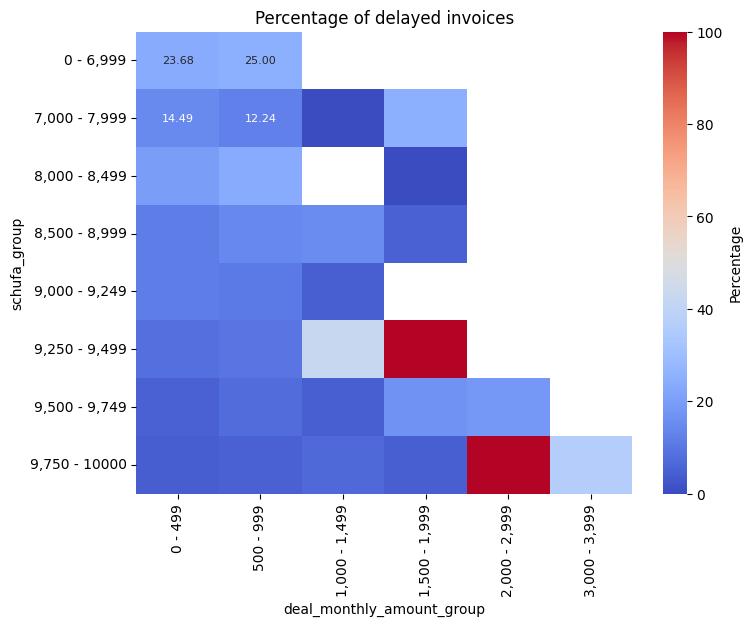

In [414]:
plt.figure(figsize=(8, 6))
heatmap_04 = sns.heatmap(pivot_04, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Percentage'}, annot_kws={'size': 8})
heatmap_04.set_title('Percentage of delayed invoices')

### Schufa Group and Age Group

In [416]:
# Count of invoices 
pivot_05_count = pd.pivot_table(merged_df, index='schufa_group', columns='age_group', values='delay_bool', aggfunc='count')

# Sum of delayed invoices
pivot_05_sum = pd.pivot_table(merged_df, index='schufa_group', columns='age_group', values='delay_bool', aggfunc='sum')

# Percentage of delayed invoices
pivot_05 = round(pivot_05_sum / pivot_05_count * 100, 2)

print('Percentage of delayed invoices: ')
pivot_05

Percentage of delayed invoices: 


age_group,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89
schufa_group,,,,,,,,
"0 - 6,999",NaN,15.38,50.00,43.48,16.67,0.00,NaN,NaN
"7,000 - 7,999",0.0,25.64,18.84,1.79,0.00,12.50,NaN,NaN
"8,000 - 8,499",NaN,19.74,25.45,14.81,20.69,0.00,NaN,NaN
"8,500 - 8,999",NaN,16.18,13.30,14.67,8.33,0.00,0.00,NaN
"9,000 - 9,249",NaN,10.83,6.54,14.14,33.33,14.29,50.00,NaN
"9,250 - 9,499",NaN,12.98,7.82,14.71,5.56,28.95,14.29,NaN
"9,500 - 9,749",NaN,7.61,4.96,7.00,4.92,3.26,28.57,NaN
"9,750 - 10000",NaN,6.69,3.61,4.62,4.32,4.99,8.00,NaN


Text(0.5, 1.0, 'Percentage of delayed invoices')

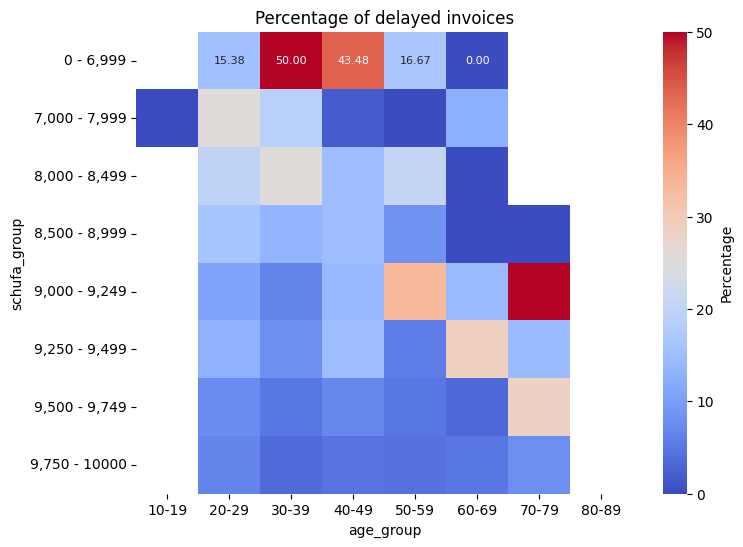

In [417]:
plt.figure(figsize=(8, 6))
heatmap_05 = sns.heatmap(pivot_05, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Percentage'}, annot_kws={'size': 8})
heatmap_05.set_title('Percentage of delayed invoices')

## Customers who delay

In [403]:
# The frequency of delayed payments for each customer
delayed_cust = (merged_df.groupby('customer_id')['delay_bool'].sum()).reset_index()

# Customers who have delayed at least one payment
delayed_cust = delayed_cust[delayed_cust['delay_bool'] > 0]

delayed_cust.rename(columns={'delay_bool' : 'delay_frq'}, inplace = True)

# Create a dataframe with characteristics of customer_id
sorted = merged_df[['customer_id', 'schufa_score', 'age', 'loyalty_status']].sort_values(by='customer_id')
first_match = sorted.drop_duplicates(subset='customer_id', keep='first')

delayed_cust = pd.merge(delayed_cust, first_match, on='customer_id', how='left')

print('\nAverage Schufa Score of the customers who delay: {}'.format(delayed_cust['schufa_score'].mean()))

print('\nAverage age of the customers who delay: {} \n'.format(round(delayed_cust['age'].mean(), 2)))

print('Loyalty status of the customers who delay: \n')
print(delayed_cust['loyalty_status'].value_counts())


Average Schufa Score of the customers who delay: 9381.843373493975

Average age of the customers who delay: 42.66 

Loyalty status of the customers who delay: 

loyalty_status
gold        288
platinum    137
silver       89
Name: count, dtype: int64


## Customers who dont pay at all

In [405]:
# Customers who have not paid
not_paid_cust = (merged_df[merged_df['paid_date'].isnull()].groupby('customer_id')['delay_bool'].sum()).reset_index()

not_paid_cust.rename(columns={'delay_bool' : 'not_paid_frq'}, inplace = True)

not_paid_cust = pd.merge(not_paid_cust, first_match, on='customer_id', how='left')

print('\nAverage Schufa Score of the customers who have not paid: {}'.format(not_paid_cust['schufa_score'].mean()))

print('\nAverage age of the customers who have not paid: {} \n'.format(round(not_paid_cust['age'].mean(), 2)))

print(not_paid_cust['loyalty_status'].value_counts())



Average Schufa Score of the customers who have not paid: 8995.647887323943

Average age of the customers who have not paid: 40.89 

loyalty_status
gold        37
silver      22
platinum    16
Name: count, dtype: int64


# Summary

## What is the share of invoices with a delayed payment per month?

| Month | Percentage of Delayed Payments |
|-------|-------------------------------|
| 1     | 5.44%                         |
| 2     | 5.14%                         |
| 3     | 5.95%                         |
| 4     | 4.42%                         |
| 5     | 6.94%                         |
| 6     | 8.33%                         |
| 7     | 5.42%                         |
| 8     | 6.71%                         |
| 9     | 6.72%                         |
| 10    | 6.61%                         |
| 11    | 7.26%                         |
| 12    | 8.16%                         |

## What is the main driver of these delayed payments?

Based on the univariate analysis, we can identify several potential drivers of delayed payments. We can assess the variables with the highest percentage of delayed payments:

### Invoice Type:
- **Final**: 50.65%
- **Monthly**: 4.37%

### Invoice Amount Group:
- **>1,999**: 50.29%
- **1,500 - 1,999**: 20.97%

### Schufa Group:
- **0 - 6,999**: 24.19%
- **8,000 - 8,499**: 20.88%

### Deal Monthly Amount Group:
- **3,000 - 3,999**: 36.36%
- **2,000 - 2,999**: 25.00%

The main driver of delayed payments appears to be the invoice type, with final invoices having a significantly higher delay rate at 50.65%. This indicates that customers are much more likely to delay payment on their final invoices compared to their monthly invoices.

## Analysis of Customers More Likely to Pay Late:

- Schufa Score: Customers with a lower Schufa score (0 - 6,999) have the highest delay rate at 24.19%, indicating a correlation between lower credit scores and delayed payments.

- Age Group: Younger customers (20-29) have a higher delay rate (9.93%) compared to other age groups, except for 70-79 which has 10.64%.

- Loyalty Status: Customers with a Silver loyalty status have a higher delay rate (13.79%) compared to Gold (5.73%) and Platinum (5.26%).

- Invoice Amount Group: Customers with invoice amounts greater than 1,999 have a much higher delay rate (50.29%).

## Suggestions:

- Implement stricter payment reminders and follow-ups for final invoices to reduce the high delay rate associated with them.

- Identify customers with high invoice amounts and proactively reach out to them to discuss payment options and offer support before the due date.

- Offer installment plans for higher invoice amounts, allowing customers to spread out the cost over several smaller payments rather than paying a lump sum. This can make payments more manageable.

-  Include clear penalty clauses for delayed payments in the contract, especially for high invoice amounts, to encourage timely payments.

- Introduce more flexible payment plans or installment options for customers with high invoice amounts to reduce the likelihood of delayed payments.

- Incorporate Schufa scores into the risk assessment process for new subscribers. Assign a risk score based on the Schufa score.

- To customers with low schufa score, offer them payment plans that match their financial capabilities and provide additional reminders.

- Provide tools or partnerships with financial management apps to help customers track their expenses and manage their payments more effectively.

- Enhance the benefits of the loyalty program to encourage timely payments, especially targeting Silver status customers to move them to Gold or Platinum statuses.

- Provide discounts or other incentives for customers who pay their invoices early. For instance, offer a 2-5% discount on the invoice amount if paid within a week of issuance.

- Adjust the billing cycle so that the majority of invoice due dates fall between the 3rd and 7th of the month.



